In [1]:
from models import MeshModel, IcosphereModel
from jax.typing import ArrayLike
from models.mesh_transform import add_rotation, evaluate_rotation
from models.spots import add_spots
from plots import plot_3D
from spectrum import simulate_spectrum, blackbody_intensity, luminosity, passband_luminosity, filter_responses, absolute_bol_luminosity
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np
from typing import Callable, Tuple
from speclite import filters
from spectrum.utils import C_CENTIMETERS
import matplotlib.pyplot as plt
from geometry import clip

from jax import config
config.update("jax_enable_x64", True)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject


An easy, solar-like model.

In [2]:
base_temp = jnp.log10(5777)
m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., jnp.concatenate([jnp.array([base_temp]), jnp.ones(19)]))

Some wavelengths.

In [3]:

vws = jnp.linspace(0., 50000., 1000)

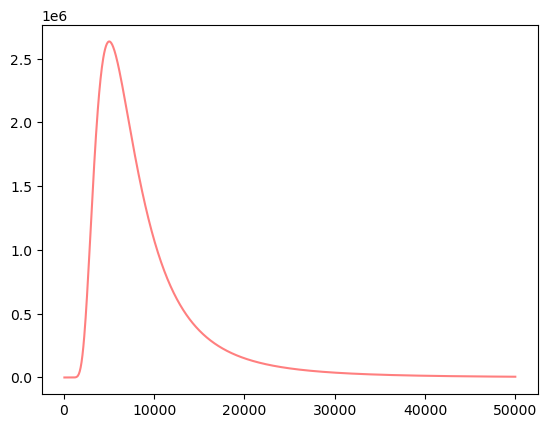

In [4]:
i = simulate_spectrum(blackbody_intensity, m, jnp.log10(vws))
plt.plot(vws, i[:, 0], color='red', alpha=0.5)

In [11]:
absolute_bol_luminosity(luminosity(i, vws, m))

Array(4.74246395, dtype=float64)

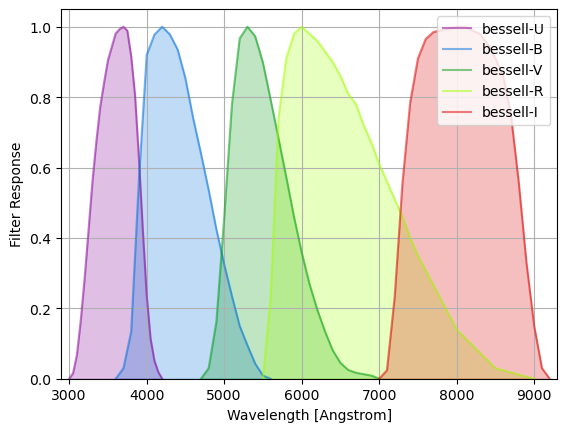

In [13]:
bessell = filters.load_filters('bessell-*')
filters.plot_filters(bessell, wavelength_limits=(2900, 9300))

In [14]:
bessell[4].__dict__

{'_wavelength': array([7000., 7100., 7200., 7300., 7400., 7500., 7600., 7700., 7800.,
        7900., 8000., 8100., 8200., 8300., 8400., 8500., 8600., 8700.,
        8800., 8900., 9000., 9100., 9200.]),
 'band_shift': None,
 '_response': array([0.   , 0.024, 0.232, 0.555, 0.785, 0.91 , 0.965, 0.985, 0.99 ,
        0.995, 1.   , 1.   , 0.99 , 0.98 , 0.95 , 0.91 , 0.86 , 0.75 ,
        0.56 , 0.33 , 0.15 , 0.03 , 0.   ]),
 'meta': {'url': 'http://dx.doi.org/10.1086/132749',
  'band_name': 'I',
  'airmass': 0.0,
  'description': 'Reference definition of the Johnson/Cousins "standard" I filter based on: Bessell, M. S., "UBVRI passbands," PASP, vol. 102, Oct. 1990, p. 1181-1199. Note that these do not represent the response of any actual instrument. Response values are normalized to have a maximum of one.',
  'group_name': 'bessell'},
 'interpolator': <scipy.interpolate._interpolate.interp1d at 0x15d466b10>,
 'effective_wavelength': <Quantity 8086.39904467 Angstrom>,
 'ab_zeropoint': <Quanti

(0.0, 15000.0)

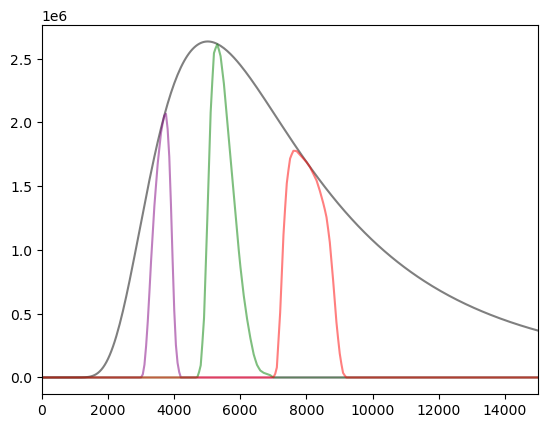

In [15]:
u_passband = filter_responses(vws, bessell[0]._wavelength, bessell[0]._response)
v_passband = filter_responses(vws, bessell[2]._wavelength, bessell[2]._response)
i_passband = filter_responses(vws, bessell[4]._wavelength, bessell[4]._response)
plt.plot(vws, i[:, 0], color='black', alpha=0.5)
plt.plot(vws, i[:, 0]*u_passband, color='purple', alpha=0.5, label='U')
plt.plot(vws, i[:, 0]*v_passband, color='green', alpha=0.5, label='R')
plt.plot(vws, i[:, 0]*i_passband, color='red', alpha=0.5, label='I')
plt.gca().set_xlim(0, 15000)

In [16]:
passband_luminosity(i, i_passband, vws, m)

Array(4.78250145e+32, dtype=float64)

In [18]:
-2.5*jnp.log10(passband_luminosity(i, i_passband, vws, m))

Array(-81.69913778, dtype=float64)

$f=\frac{c}{\lambda}$

$f_\nu\ [\rm{ergs}\ s^{-1} \rm{cm}^{-2} \rm{Hz}^{-1}] = 
\frac{\lambda}{c}^2\cdot 10^8\cdot f_\lambda\ [\rm{ergs}\ s^{-1} \rm{cm}^{-2} \AA^{-1}]$

In [30]:
def flux_density_hz(wavelengths: ArrayLike,
                    flux_density_A: ArrayLike) -> Tuple[ArrayLike, ArrayLike]:
    
    freqs = C_CENTIMETERS/(wavelengths*1e-8)
    return freqs, jnp.power(wavelengths, 2)/C_CENTIMETERS*1e8*flux_density_A

In [39]:
hz, fhz = flux_density_hz(vws, i[:, 0]*i_passband)
p = luminosity(jnp.repeat(fhz.reshape((-1, 1)), axis=1, repeats=2), jnp.nan_to_num(hz), m)

In [41]:
p

Array(-4.78313937e+48, dtype=float64)

In [35]:
-2.5*jnp.log10(p)

Array(nan, dtype=float64)

In [53]:
-2.5*jnp.log10(passband_luminosity(i, i_passband, vws, m))+2.5*jnp.log10(2.48*1e-9*1e-7)

Array(-120.71298229, dtype=float64)

(0.0, 15000.0)

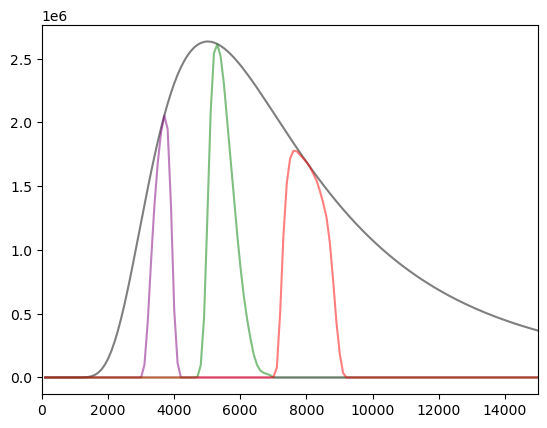

In [ ]:
u_luminosity = absolute_bol_luminosity(passband_luminosity(i, u_passband, vws, m))
v_luminosity = absolute_bol_luminosity(passband_luminosity(i, v_passband, vws, m))
i_luminosity = absolute_bol_luminosity(passband_luminosity(i, i_passband, vws, m))

In [137]:
-2.5*jnp.log10(passband_luminosity(i, i_passband, vws, m))

Array(-81.69911149, dtype=float64)

In [138]:
passband_luminosity(i, i_passband, vws, m)

Array(4.78238566e+32, dtype=float64)

In [123]:
passband_luminosity(i, i_passband, vws, m), luminosity(i, vws, m)

(Array(4.78238566e+32, dtype=float64), Array(3.83655376e+33, dtype=float64))